# <center> Линейная регрессия. Практика

## <center> Предсказываем индивидуальные медицинские расходы граждан США

✍ Настало время попрактиковаться применять модель линейной регрессии и её модификации в задачах регрессии.

Работать будем с популярным датасетом [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance).

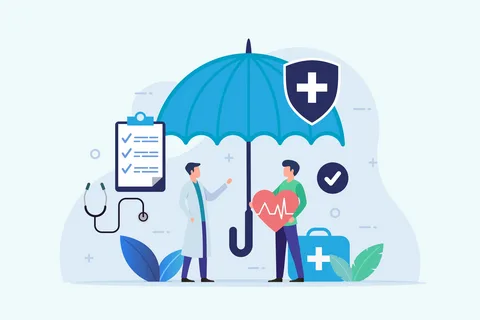

In [53]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

Процесс разработки DS-проектов согласно методологии CRISP-DM.

Этапы модели CRISP-DM:

1. Анализ требований
2. Исследование данных
3. Подготовка данных
4. Моделирование
5. Оценка модели
6. Внедрение

### Анализ требований

В этот раз мы коснёмся мира медицинского страхования. Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

**Знакомство с данными**

In [54]:
#Прочитаем данные:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

* age — возраст страхователя;
* sex — пол;
* bmi — индекс массы тела ($кг/м^{2}$), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [55]:
#Размер таблицы:

print(data.shape)
# (1338, 7)

(1338, 7)


In [56]:
#Выведем информацию о пропусках и посмотрим на типы данных, так как наличие пропусков не позволит нам построить модель 
#линейной регрессии:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Наши данные содержат несколько типов признаков:

* age, bmi, children — числовые признаки;
* sex, smoker — бинарные категориальные переменные (две категории);
* region — множественные категориальные переменные (несколько категорий);
* charges — числовой целевой признак.

### Исследование данных

Цель этого шага — понять слабые и сильные стороны предоставленных данных, определить их достаточность, оценить взаимосвязи между признаками и предложить идеи, как их использовать.

Выводим описательные статистики для числовых и категориальных признаков

In [57]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [58]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [59]:
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()

Проведем небольшое исследование зависимости целевого признака price от числовых признаков.

In [60]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

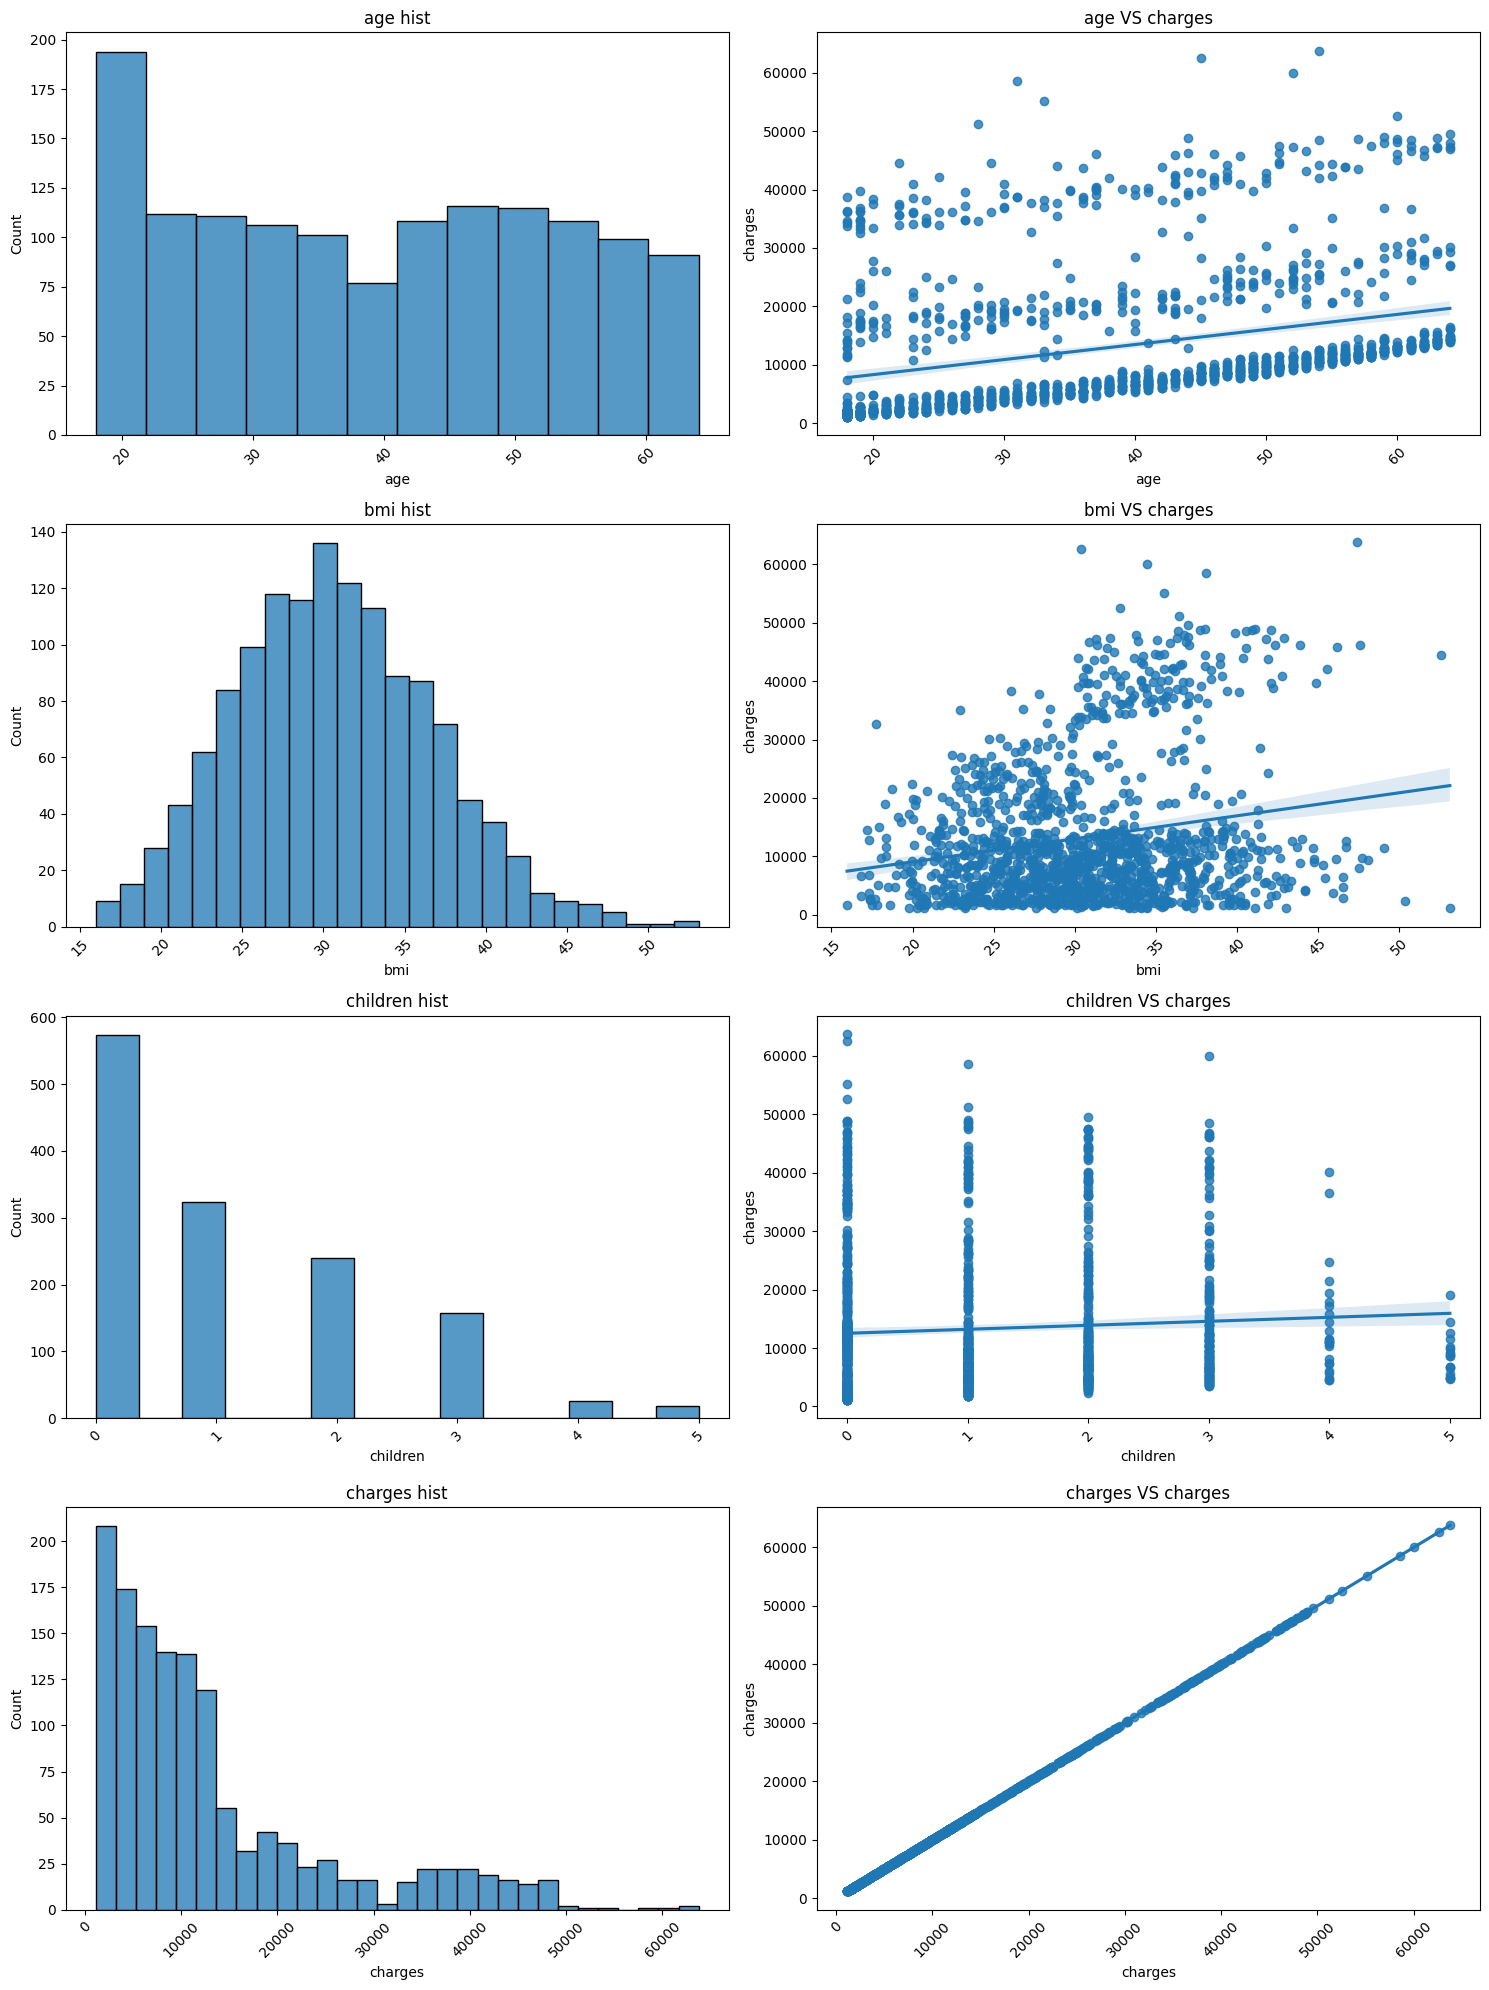

In [61]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

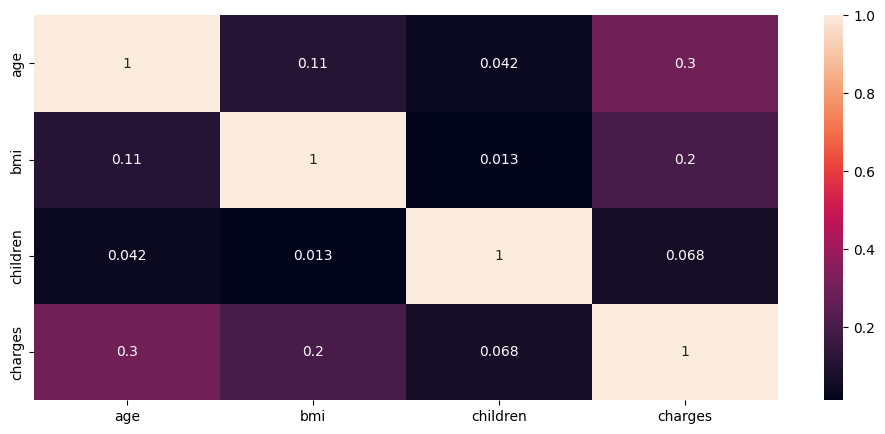

In [62]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(numeric_only=True), annot=True);

### Подготовка данных

Цель этого этапа — подготовить обучающую выборку для использования в моделировании.

Прежде чем приступать к этапу подготовки данных для модели, можно произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

* гистограммы/коробчатые диаграммы числовых признаков;
* столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
* диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

#### Визуализация данных

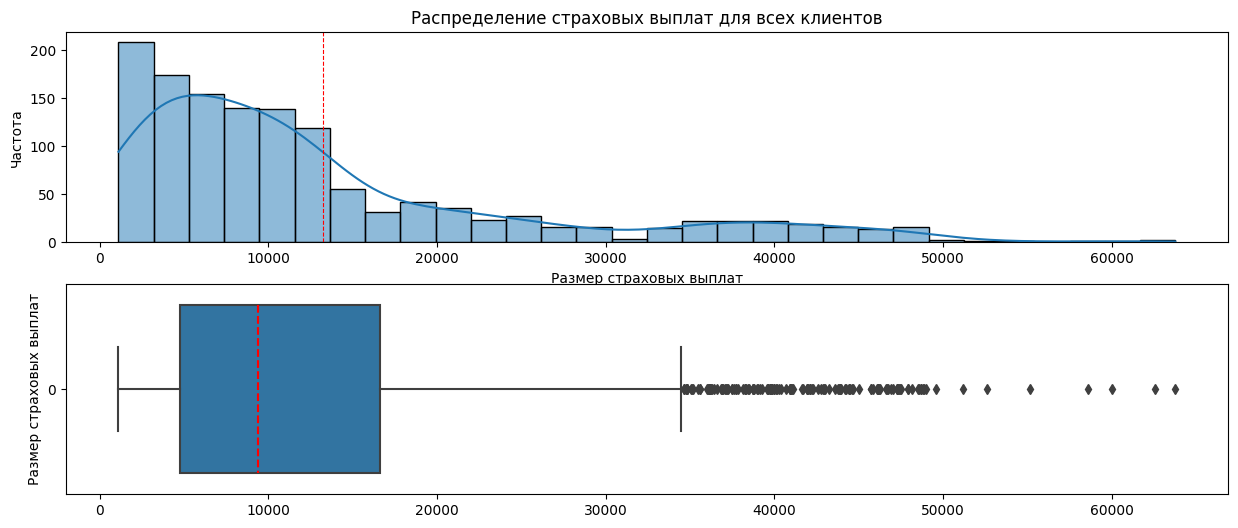

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
sns.histplot(data['charges'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер страховых выплат', ylabel='Частота')
axes[0].set_title('Распределение страховых выплат для всех клиентов')
axes[0].axvline(data['charges'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['charges'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'});
axes[1].set(ylabel='Размер страховых выплат');

##### Вывод: Распределение страховых выплат отлично от нормального, имеются выбросы.

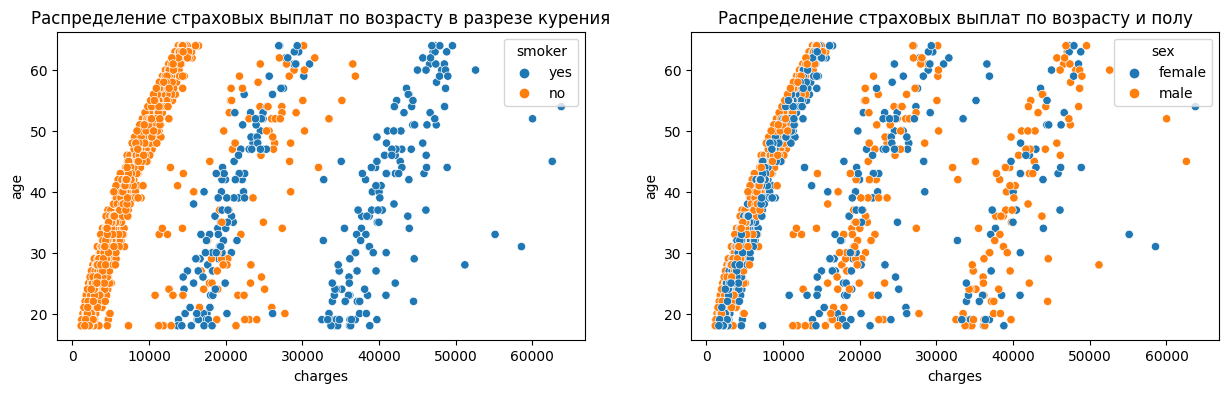

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.scatterplot(data=data, x='charges', y='age', hue='smoker', ax=axes[0]);
sns.scatterplot(data=data, x='charges', y='age',hue='sex',ax=axes[1]);
axes[0].set_title('Распределение страховых выплат по возрасту в разрезе курения');
axes[1].set_title('Распределение страховых выплат по возрасту и полу');

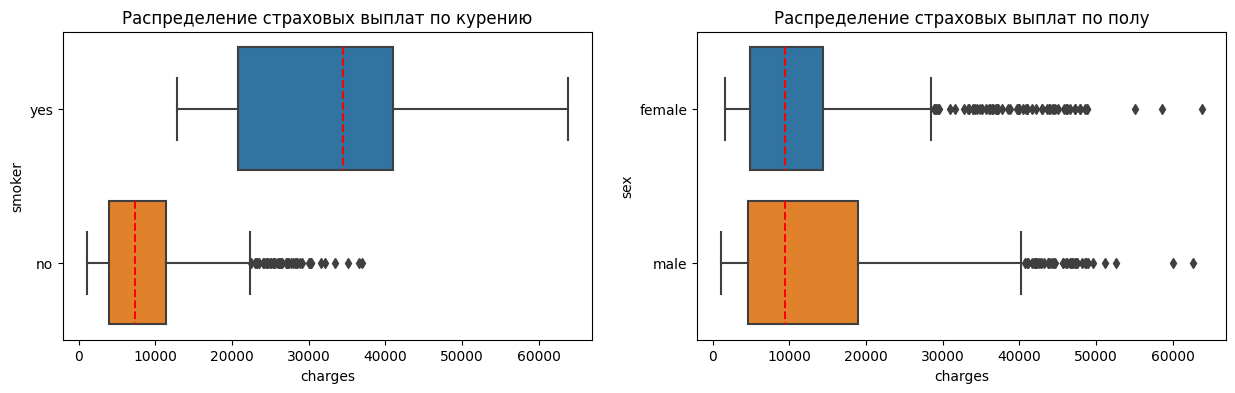

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.boxplot(data, x='charges', y='smoker', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0]);
sns.boxplot(data, x='charges', y='sex', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1]);
axes[0].set_title('Распределение страховых выплат по курению');
axes[1].set_title('Распределение страховых выплат по полу');

##### Вывод: Распределения страховых выплат для разных полов различны, тоже можно и сказать о возрасте. Из диаграммы, которая показывает курит ли человек или нет, можно сделать вывод, что те кто курят имеют более высокие выплаты по мед.страховкам, чем те, кто не курит.

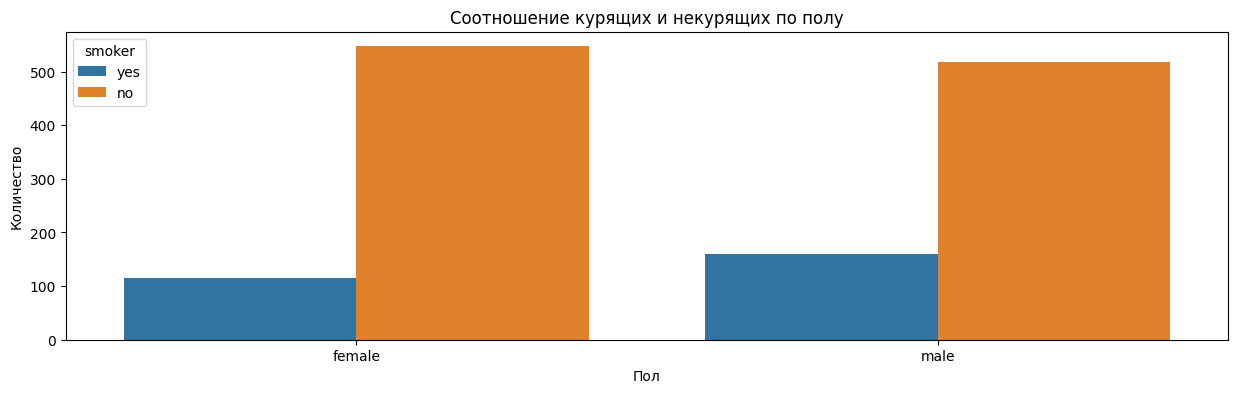

In [66]:
fig, axes = plt.subplots(figsize=(15, 4))
ax = sns.countplot(data=data, x=data['sex'], hue='smoker')
ax.set(xlabel='Пол', ylabel='Количество')
plt.title('Соотношение курящих и некурящих по полу')
plt.show()

##### Вывод: Согласно данным, среди курящих мужчин больше, чем женщин.

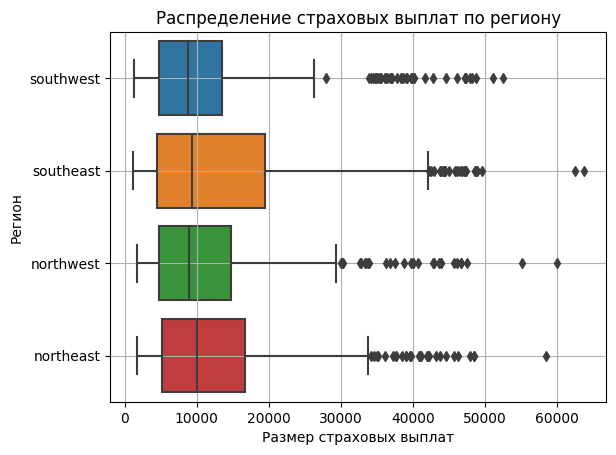

In [67]:
boxplot = sns.boxplot( data=data, x='charges', y='region', orient='h')
boxplot.set_title('Распределение страховых выплат по региону');
boxplot.set_xlabel('Размер страховых выплат');
boxplot.set_ylabel('Регион');
boxplot.grid()

##### Вывод: Распределения страховых выплат различны для разных регионов.

In [68]:
def bmi_distribution(bmi):
    if 0 < bmi <=16:
        return 'deficit'
    elif 16 <= bmi <= 18.5:
        return 'Insufficient weight'
    elif 18.5 <= bmi <= 25:
        return 'Standard'
    elif 25 <= bmi <= 30:
        return 'Overweight'
    elif 30 <= bmi <=35:
        return 'Obesity of the 1st degree'
    elif 35 <= bmi <=40:
        return 'Obesity of the 2nd degree'
    elif bmi > 40:
        return 'Obesity of the 3rd degree'
temp_data['bmi'] = temp_data['bmi'].apply(bmi_distribution)

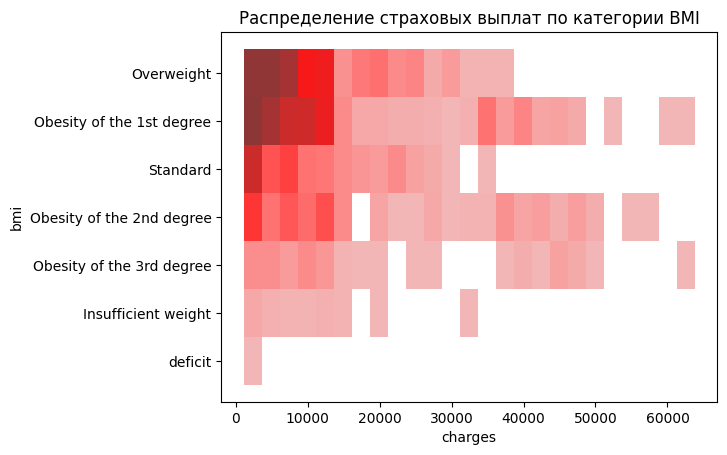

In [69]:
hist = sns.histplot(data=temp_data, x='charges', y='bmi', bins=25, color='red');
hist.set_title('Распределение страховых выплат по категории BMI');

##### Вывод: Из диаграммы видно, что большая часть распределения страховых выплат сосредоточена у людей с избыточным весом и ожирением 1 степени. Таже можно сделать вывод что большая часть распределения страховых выплат не превышает более 2000$.

#### Кодирование данных

Линейная регрессия, которую мы будем использовать, является моделью, которая требует численного представления данных. То есть на этапе подготовки данных мы должны позаботиться о кодировании текстовых категориальных признаков. 

К тому же, если в ваших данных присутствуют пропуски данных, то необходимо обратать и их, так как пропуски в данных вызовут ошибку при подаче данных в модель.

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [70]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [71]:
#X - матрица наблюдений, y - столбец правильных ответов
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

### Моделирование + Оценка модели

**Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество**

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [72]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

#### **Задание 6.1. Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.В качестве значения параметра random_state укажите число 42.Чему равно количество наблюдений в тестовом наборе данных?**

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [73]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


**Модель линейной регрессии:**

Модель линейной регрессии имеет следующий вид:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры линейной регрессии

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 

В качестве функции потерь используем MSE - средний квадрат ошибки.

$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$

**Аналитическое решение: метод наименьших квадратов (OLS):**

$$\omega=(X^TX)^{-1}X^Ty$$

В библиотеке sklearn линейная регрессия с поиском параметров по OLS реализована в классе LinearRegression модуля linear_model. 

Методы:
* fit() - подгонка параметров по OLS (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные с помощью OLS коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

#### **Задание 6.2. Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.**

In [74]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

print(np.round(lr_model.intercept_, 2))

y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)

-12390.8


#### **Задание 6.3. С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики. Не забудьте привести значение  к процентам.Значение  округлите до трёх знаков после точки-разделителя, а значения  и  — до целого числа.Чему равны значения метрик на тренировочной и тестовой выборках?**

In [75]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Train MAPE: 47


#### **Задание 6.4. Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием:  (без модуля)**.

Посмотрим на разброс ошибок нашей модели с помощью boxplot-диграммы. Это поможет нам понять, как много мед.страховок в каждой из выборок, для которых мы допускаем высокую ошибку в предсказании расходов.

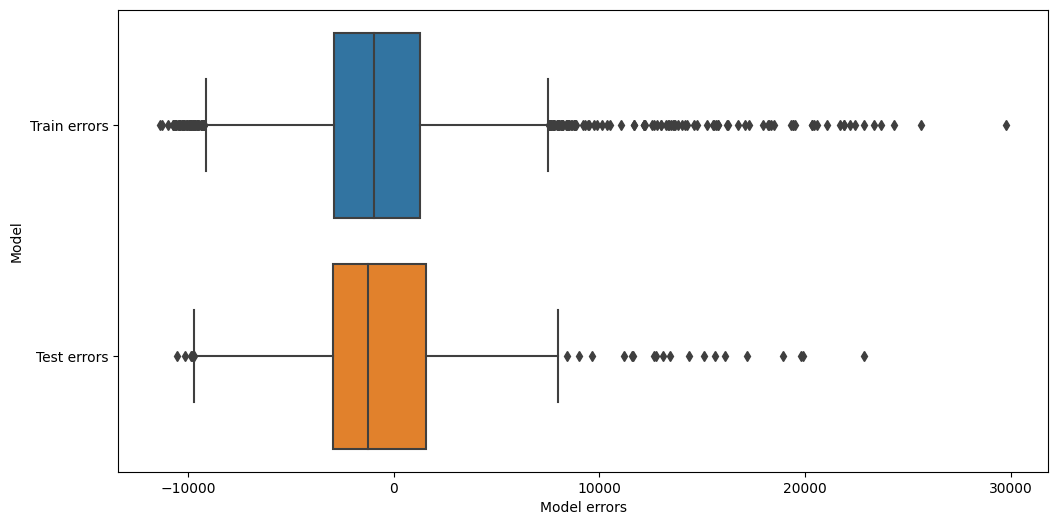

In [76]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - lr_model.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr_model.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

**Численное решение: метод стохастического градиентного спуска (SGD):**

$$\omega^{(k+1)} = \omega^{(k)} - \eta\nabla L(\omega^{(k)})$$

В библиотеке sklearn линейная регрессия с поиском параметров по SGD реализована в классе SGDRegressor модуля linear_model. 

Методы:
* fit() - подгонка параметров по SGD (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - полученные с помощью SGD коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

#### **Задание 6.5. Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.Чему равно результирующее количество столбцов?**

In [77]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


#### **Задание 6.6. Обучите модель линейной регрессии на полиномиальных признаках.Чему равно значение метрики  на тестовой выборке?Значение  округлите до трёх знаков после запятой.**

In [78]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_scaled_poly)

#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.842
Test R^2: 0.866


#### **Задание 6.7.Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.Какой вывод можно сделать?**

In [79]:
print(lr_model_poly.coef_)

[ 3.28425930e+16  5.24092415e+15 -3.54274027e+15  5.56107133e+15
 -4.36104954e+15 -4.32544728e+15 -1.27568697e+17 -1.54961145e+16
 -5.06580635e+16  8.44000000e+03  8.78000000e+02  8.20000000e+02
 -1.73200000e+03  1.84000000e+02 -3.28425930e+16 -3.28425930e+16
 -3.28425930e+16 -3.28425930e+16 -5.62830332e+16  7.20250000e+02
 -1.29050000e+03  2.70000000e+02  5.10421091e+16  5.10421091e+16
  5.10421091e+16  5.10421091e+16 -9.74062500e+03  1.60400000e+03
  5.48413125e+04  3.54274027e+15  3.54274027e+15  3.54274027e+15
  3.54274027e+15 -2.08000000e+03 -2.18400000e+03 -5.56107133e+15
 -5.56107133e+15 -5.56107133e+15 -5.56107133e+15 -2.08317967e+15
  6.44422921e+15  6.44422921e+15  6.44422921e+15  6.44422921e+15
 -1.82552363e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.04988013e+17  0.00000000e+00  0.00000000e+00 -7.08456908e+15
  0.00000000e+00  2.80773799e+16]


**Линейная регрессия c L1-регуляризациeй (Lasso)**

L1-регуляризация (Lasso)  добавление к функции потерь суммы модулей коэффициентов, умноженных на коэффициент регуляризации $\alpha$:

$$L_{1}(w)=M S E+\alpha \sum_{j=1}^{m}\left|w_{j}\right|$$

#### **Задание 6.8. Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000. Чему равны метрики $R^{2}$,$MAE$ и $MAPE$ на тестовой выборке?Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.**

In [80]:
lasso_lr_poly = linear_model.Lasso()
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

print(lasso_lr_poly.coef_)

Train R^2: 0.842
Train MAE: 2889
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2718
Train MAPE: 30
[ 3254.29444013  -497.77667434  5082.44296811  4579.96903719
 11174.5885881     92.27997327  -474.0824118    585.76537158
  -243.94757338  8291.3159849    776.44311147   834.79828593
 -1211.25190072   133.7834509  -1044.725423      -0.
  1169.28596708  1614.02590931    -0.           511.03215486
 -1132.38078219   266.01794461 -1221.18415878     0.
   239.00186822  -577.34015094 -8185.15426742  1294.30664583
 54733.92609325  3582.81956575  2403.95450092  -968.57471909
    -0.         -1670.63577613 -2056.02514315  1943.04187366
  1954.4503939      0.         -1061.93641958 -8575.11156654
    -0.          -592.75085202  -851.52193562  1359.94923273
   723.55006857     0.             0.             0.
    -0.             0.             0.             0.
     0.            -0.        ]


c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


**Вывод**: параметры пришли к нормальным значениям, что говорит об устойчивости модели.

**Линейная регрессия с L2-регуляризацией**

L2-регуляризация добавляет к функции ошибки дополнительное слагаемое, которое вносит смещение в обучение модели. Слагаемое - сумма квадратов коэффициентов модели.

$$L(\omega) = MSE + \alpha \sum_{j=1}^{m}{\omega_j^2}$$

$\alpha$ - коэффициент регуляризации, чем он выше, тем большее смещение вносится в модель (тем сильнее штраф за переобучение)

В библиотеке sklearn линейная регрессия с L2-регуляризацией (гребневая регрессия) реализована в классе Ridge модуля linear_model. 

Методы:
* fit() - подгонка параметров по методу координатного спуска - безпроизводный аналов градиентного спуска (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

#### **Задание 6.9. Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.Чему равны метрики ,  и  на тестовой выборке?Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.**

In [81]:
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Train MAPE: 31


Качество модели можно улучшить, если подробовать подобрать оптимальное значение коэффициента регуляризации $\alpha$ (по умолчанию в реализации sklearn $\alpha = 1$)

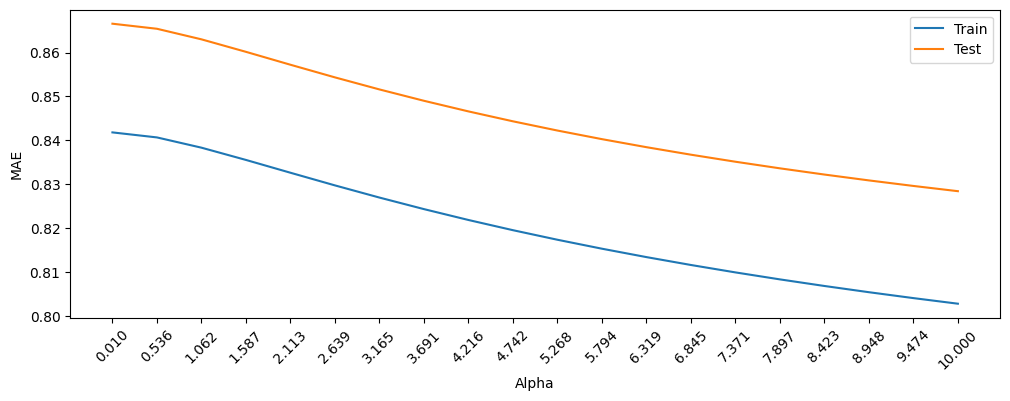

In [85]:
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=2000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
    y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    #train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    #test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

In [86]:
ridge_lr_poly = linear_model.Ridge(alpha=0.01)
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2892
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2730
Train MAPE: 30


**Возможные дальнейшие шаги по улучшению**:
* feature engineering - попыться сгенерировать новые признаки в данных/присоединить внешние источники, например данные о bmi распределить по группам
* попытаться привести все числовые признаки к нормальному распределению (например, с помощью логарифмирования)
* найти наблюдения, для которых наблюдается высокая ошибка между предсказанием и действительностью и понять, что с ними "не так"